In [1]:
import json
import pandas as pd
from statistics import mean
from collections import Counter
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

In [2]:
def load_data(path='../data/raw/train.json'):

    with open(path,'r') as file:
        data = json.load(file)

    return data



In [3]:
data = load_data(path = 'data/annotation/master.json' )

mean([ dp[ 'fleiss-kappa'] for idx,dp in data.items() ])

0.013760815833008314

In [29]:
filepath = "data/labelled_data/"
all_files = os.listdir(filepath)
comments = {}
posts = {}
for fname in tqdm(all_files):
    file = pd.read_csv(filepath+fname,sep='\t').drop('Unnamed: 0',axis=1)
    if 'submission' in fname:
        posts['_'.join(fname.split('_')[3:6])] = file

        
subset = []
for date,df in posts.items():
    df['date'] = date
    subset.append(df)

merged_posts = pd.concat(subset)
  

100%|██████████| 590/590 [00:06<00:00, 90.96it/s]


In [30]:
dims = ['conflict','similarity','knowledge','power','status','support','identity','romance','trust','fun']
scores_per_dim = { dim : [] for dim in dims}
cnt = 0
ids_not_fount= []
for idx, dp in data.items():

    row_df = merged_posts.loc[merged_posts['id'] == dp['id']]
    if row_df.shape[0] == 1:
        temp_dim_cnt = Counter()
        annotator_cnt = len(dp['annotations'])
        for annotator, labels in dp['annotations'].items():
            
            labels =  [lab.lower() for lab in labels]
            temp_dim_cnt.update(labels) 
        
        for dim in dims:
            ann_ratio = 0
            if annotator_cnt != 0:
                ann_ratio = temp_dim_cnt[dim]/annotator_cnt
            
            scores_per_dim[dim].append((row_df[dim].iloc[0], ann_ratio))
    else:
        ids_not_fount.append(dp['id'])

In [31]:
len(scores_per_dim[dims[2]])


187

In [32]:
def annotated_of_dim(dim, scores_per_dim,annotation_ratio  = 0.5):

    dim_list = scores_per_dim[dim]
    included_l = []
    excluded_l = []
    for model_v, ann_v in dim_list: 
        if ann_v >= annotation_ratio:
            included_l.append( model_v )
        else:
            excluded_l.append( model_v)
    if not included_l:
        included_l.append(0)
    return included_l, excluded_l



In [33]:
def plot_bar(p_list,title= ''):
    
    plt.style.use('fivethirtyeight')

    plt.figure(figsize=[6,2])
    plt.xticks(rotation= 45)
    plt.title(title)
    plt.xlim([0,1])
    plt.hist(p_list)
    plt.axvline(mean(p_list), color='k', linestyle='dashed', linewidth=1)
    plt.show()
    plt.clf()

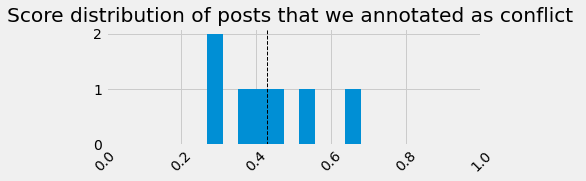

<Figure size 432x288 with 0 Axes>

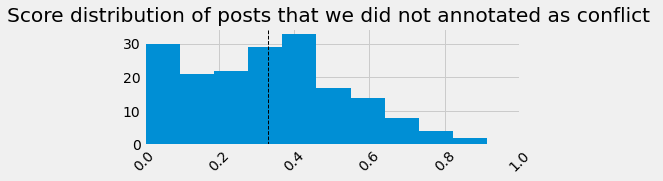

<Figure size 432x288 with 0 Axes>

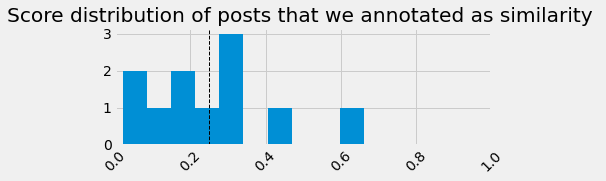

<Figure size 432x288 with 0 Axes>

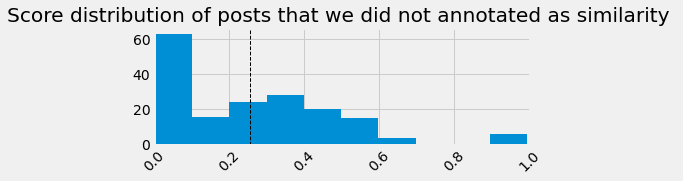

<Figure size 432x288 with 0 Axes>

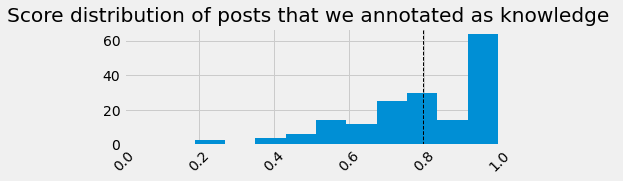

<Figure size 432x288 with 0 Axes>

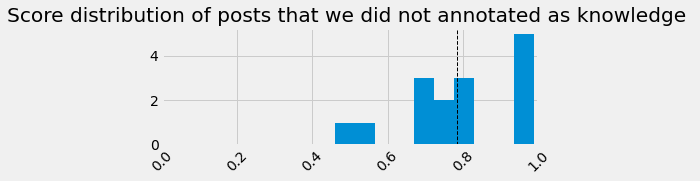

<Figure size 432x288 with 0 Axes>

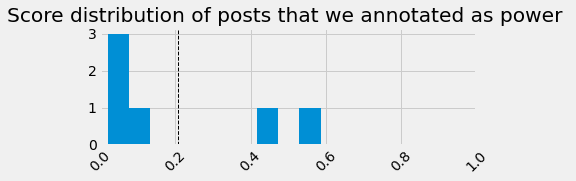

<Figure size 432x288 with 0 Axes>

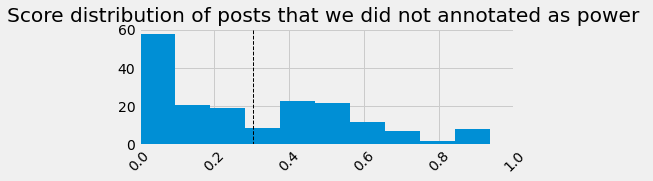

<Figure size 432x288 with 0 Axes>

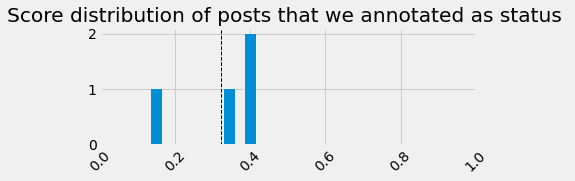

<Figure size 432x288 with 0 Axes>

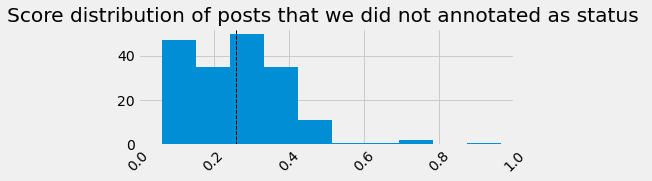

<Figure size 432x288 with 0 Axes>

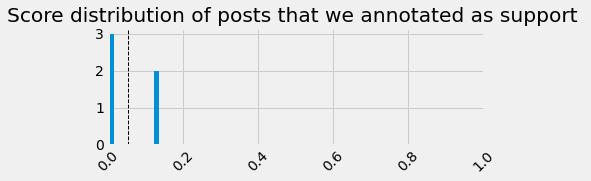

<Figure size 432x288 with 0 Axes>

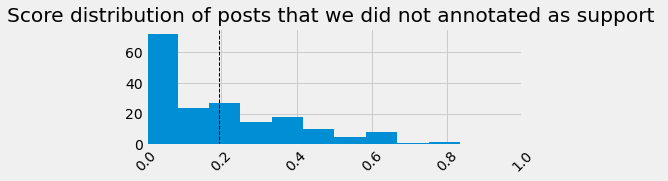

<Figure size 432x288 with 0 Axes>

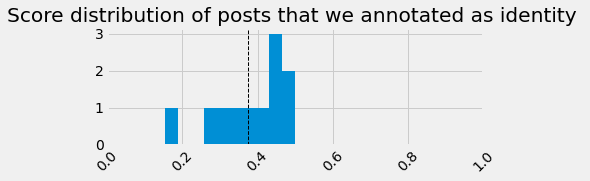

<Figure size 432x288 with 0 Axes>

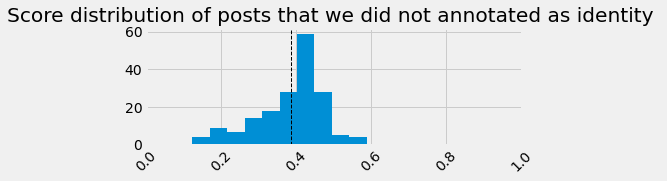

<Figure size 432x288 with 0 Axes>

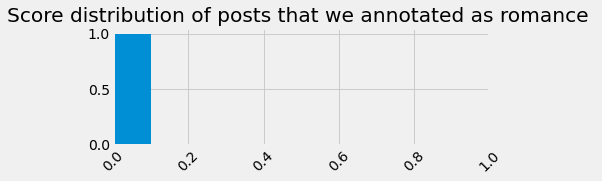

<Figure size 432x288 with 0 Axes>

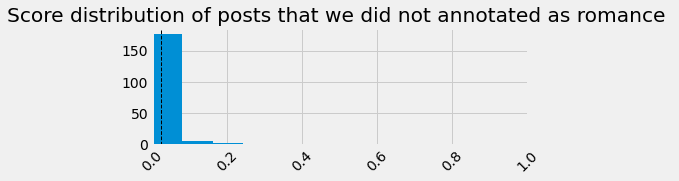

<Figure size 432x288 with 0 Axes>

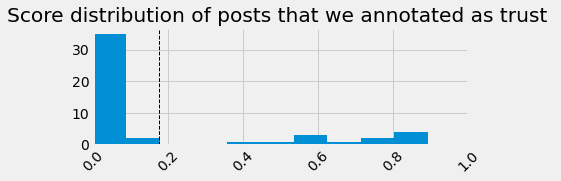

<Figure size 432x288 with 0 Axes>

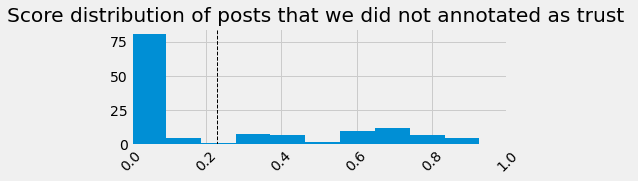

<Figure size 432x288 with 0 Axes>

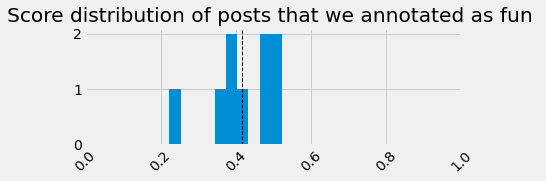

<Figure size 432x288 with 0 Axes>

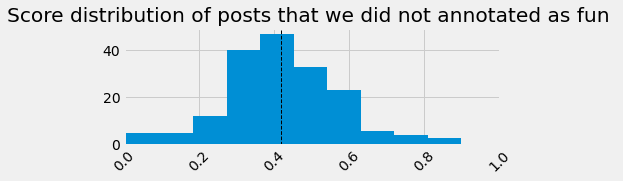

<Figure size 432x288 with 0 Axes>

In [34]:

for dim in dims:
    #print(dim)
    ann_list,other_list = annotated_of_dim(dim, scores_per_dim, annotation_ratio= 0.5)
    
    #print( "Trash hold: ", trash_hold, "Other values average: ", other_avg)
    plot_bar(ann_list, title = f'Score distribution of posts that we annotated as {dim} ')
    plot_bar(other_list, title= f'Score distribution of posts that we did not annotated as {dim} ')


(array([1., 0., 0., 0., 1., 2., 1., 0., 2., 2.]),
 array([0.22358918, 0.25361809, 0.283647  , 0.31367591, 0.34370482,
        0.37373373, 0.40376264, 0.43379155, 0.46382046, 0.49384937,
        0.52387828]),
 <BarContainer object of 10 artists>)

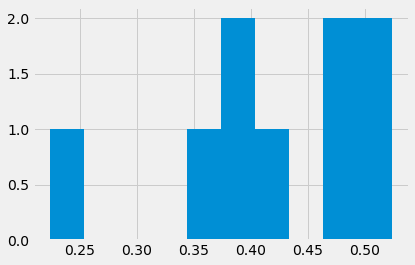

In [19]:
plt.hist(ann_list)